In [1]:
from ckanapi import RemoteCKAN
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from pandas.io.json import json_normalize

ua = 'avoindata_ckanapi_example/1.0 ({0})'
ckan = RemoteCKAN('https://beta.avoindata.fi/data/fi/', user_agent=ua)
packages = ckan.action.package_search(q='Kansaneläkelaitos', fq = 'title:etuuksien')
resources = packages['results'][0]['resources'] 
url_csv = resources[0]['url']
url_json = resources[1]['url']
dat = pd.read_csv(url_csv, sep = ';', decimal = ',')

In [2]:
response = urlopen(url_json)
meta = json.loads(response.read())

## Datan ja metadatan kuvailu

**Datan kuvaustieto**

In [3]:
print(meta['description'])

Aineisto sisältää tiedot Kelan maksamien etuuksien saajista, maksetuista etuuksista ja keskimääräisistä etuuksista (euroa/saaja). Raportti kattaa valtaosan Kelan maksamista etuuksista. Maksetuista etuuksista kuitenkin puuttuvat työnantajien järjestämästä työterveyshuollosta, yrittäjien työterveyshuollosta ja opiskelijoiden terveydenhuollosta maksetut korvaukset. Eläkkeistä, vammaisetuuksista, asumistuista ja elatustuesta ei tilastoida vuoden aikana etuutta saaneita henkilöitä eikä keskimääräisiä etuuksia. Näistä etuuksista tilastoidaan ainoastaan poikkileikkaushetken tiedot kuukausittain. Yleisen asumistuen tilastoinnissa saajien tilastoyksikkö on asumistuen ruokakunta, ja keskimääräinen etuus tilastoidaan asumistuen ruokakuntaa kohti. Opintolainavähennys on verovähennys, joten maksettua etuutta ei ole. Perustoimeentulotuen tilastoinnissa saajien tilastoyksikkö on toimeentulotuen kotitalous, ja keskimääräinen etuus tilastoidaan toimeentulotuen kotitaloutta kohti.


**Datan muuttujatieto**

In [4]:
json_normalize(meta['resources'][0]['schema']['fields'])

,format,name,type,values
0,default,kuntanumero,integer,"[5, 9, 10, 16, 18, 19, 20, 35, 43, 46, 47, 49,..."
1,default,kunta,string,"[Alajärvi, Alavieska, Alavus, Asikkala, Askola..."
2,default,aikajakso,string,"[vuosi, kuukausi]"
3,default,etuus,string,"[Kuntoutus, Opintolainan korkoavustus, Yleinen..."
4,default,saajat,number,"[4, 999]"
5,default,maksetut_etuudet_euroa,number,"[-16773, 999952]"
6,default,euroa_per_saaja,number,"[-1290.2, 12083.58]"
7,default,vuosi,integer,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201..."
8,default,kuukausi,integer,"[NA, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]"


**Datan ensimmäiset rivit**

In [5]:
print(dat.head())

   kuntanumero      kunta aikajakso      etuus  saajat  \
0            5   Alajärvi     vuosi  Kuntoutus   210.0   
1            9  Alavieska     vuosi  Kuntoutus    41.0   
2           10     Alavus     vuosi  Kuntoutus   240.0   
3           16   Asikkala     vuosi  Kuntoutus   119.0   
4           18     Askola     vuosi  Kuntoutus    52.0   

   maksetut_etuudet_euroa  euroa_per_saaja  vuosi  kuukausi  
0                495806.0          2360.98   2007       NaN  
1                143525.0          3500.61   2007       NaN  
2                612924.0          2553.85   2007       NaN  
3                299271.0          2514.88   2007       NaN  
4                175090.0          3367.12   2007       NaN  


In [8]:
plotdat = (dat
 .query('aikajakso == "vuosi"')
 .query('vuosi == 2017')
 .query('etuus == "Kuntoutus"')
 .sort_values(by='euroa_per_saaja', ascending=False)
 .head(20))

#plt.bar(plotdat, height = )

## Kuvio

<BarContainer object of 20 artists>

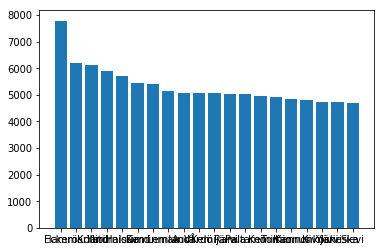

In [9]:
plt.bar(plotdat['kunta'], plotdat['euroa_per_saaja'])

## Datastore-api

Jos et tarvitse koko aineistoa, voit suodattaa siitä osio SQL:llä käyttäen CKAN:n DataStore-rajapintaa.

Alla olevassa esimerkissä tehdään rajaus `kunta`-muuttujasta ja siis etsitään vaan kuntaa *Veteli* koskevat tiedot.

In [10]:
kunta = "Veteli"
taulu = resources[0]['id']
muuttuja = 'kunta'
urli = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}" WHERE {muuttuja} LIKE \'{kunta}\''
urli_plain = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}"'
#urli = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\" WHERE %s LIKE '%s'" % (taulu, muuttuja, kunta)
#urli_plain = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\"" % (taulu)
response = urlopen(urli_plain)
da = json.loads(response.read())
dataa = json_normalize(da['result']['records'])
#dataa
print(dataa.head())

                                          _full_text  _id aikajakso  \
0  '2007':9 '210':5 '2360':7 '495806':6 '5':1 '98...    1     vuosi   
1  '143525':6 '2007':9 '3500':7 '41':5 '61':8 '9'...    2     vuosi   
2  '10':1 '2007':9 '240':5 '2553':7 '612924':6 '8...    3     vuosi   
3  '119':5 '16':1 '2007':9 '2514':7 '299271':6 '8...    4     vuosi   
4  '12':8 '175090':6 '18':1 '2007':9 '3367':7 '52...    5     vuosi   

       etuus euroa_per_saaja      kunta kuntanumero kuukausi  \
0  Kuntoutus         2360,98   Alajärvi           5       NA   
1  Kuntoutus         3500,61  Alavieska           9       NA   
2  Kuntoutus         2553,85     Alavus          10       NA   
3  Kuntoutus         2514,88   Asikkala          16       NA   
4  Kuntoutus         3367,12     Askola          18       NA   

  maksetut_etuudet_euroa saajat vuosi  
0                 495806    210  2007  
1                 143525     41  2007  
2                 612924    240  2007  
3                 299271    